# "Speed: Fastai vs HuggingFace nlp Datasets"

> Speed-test: Fastai's `TextDataloders` vs HuggingFace's `nlp` Datasets

- badges: true
- categories: [nlp, fastai, dataloader]
- image: images/bokeh_mini.png

## tl;dr
- Fastai's `Textdataloader` is well optimised and appears to come in faster on `nlp` Datasets for a dataset of 1.6M

## Speed
I started playing around with HuggingFace's [`nlp` Datasets library](https://huggingface.co/nlp) recently and was blown away by the speed at which you can iterate through the data, thanks to some PyArrow wizardry its seriously fast!

> twitter: https://twitter.com/Thom_Wolf/status/1272512974935203841

So I wondered if there was a significant speed up to be gained by doing as much text processing as I could with this library as opposed to Fastai's default text processing. (Also, after previously discovering Fastai's functionality to do [faster text loading](https://forums.fast.ai/t/nlp-speed-up-if-using-sorteddl/74636) I was in the mood for further speed-ups! 💨)


## `nlp` Datasets

The [`nlp` Datasets library](https://huggingface.co/nlp) is incredibly memory efficient:

> It provides a very efficient way to load and process data from raw files (CSV/JSON/text) or in-memory data (python dict, pandas dataframe) with a special focus on memory efficency and speed. As a matter of example, **loading a 18GB dataset like English Wikipedia allocate 9 MB in RAM** and you can iterate over the dataset **at 1-2 GBit/s** in python.

It also hosts 130+ common nlp research datasets AND (thanks to [this pointer from Thomas Wolf](https://discuss.huggingface.co/t/nlp-0-3-0-is-out/50/3) on the new HuggingFace forums) I also learned that you can also easily load your own CSVs (or jsons, pandas dataframes) and bask in all of that speedy goodness, for example like below:

```
from nlp import load_dataset
dataset = load_dataset('csv', data_files='my_file.csv')
```

By the way, if you're curious to learn more about PyArrow then I highly recommend Dejan Simic's [post about it](https://towardsdatascience.com/apache-arrow-read-dataframe-with-zero-memory-69634092b1a)

> twitter: https://twitter.com/simicdds/status/1276521257304023046

> Note: If you love the sound of laptop fans spinning like sonic the hedgehog 🦔, redhot battery packs 🔥 and the adrenaline 😰 of living on the edge  of pandas' capabilities as you explore, plot and manipulate your giant text datasets, then the `nlp` Datasets library probably isn't for you. 

Otherwise, regardless about using it for your final DL pipeline or not, `nlp` Datasets is definitely worth using just for the shear speed at which it can apply functions to GB's of data.

So, is it faster? Lets see! 

## The Setup

To find out we'll be comparing Fastai's high-level `TextDataloders` class to a custom dataprocessing pipeline using HuggingFace's `nlp` datasets library.

#### Fastai
This Fastai class does a bunch of different things, all by calling just 1 line of code, including:
- Pre and Post Processing
- Tokenization with Spacy's tokenizer, including creating a vocabulary and **parallelising** the tokenization
- Speed optimizations including sorting data by text sample length and padding only to the longest item in the sequence, [similar what was described here](https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e)
- Creating the train and validation dataloaders and putting them onto the gpu

#### HuggingFace `nlp` Datasets
The `nlp` Datasets pipeline I wrote tries to replicate all of the core functionality of `TextDataloaders` as best I could. 

> Note: I couldn't figure out how to parallelise the text processing with `nlp` although this is probably down to my lack of experience with parallelism as opposed to a limitation of the library

## Sentiment Dataset
For this experiment I used the [Sentiment140](https://huggingface.co/datasets/sentiment140) dataset, a sentiment classifcation dataset of Twitter data. 

For our experiment we'll use
- 10% of sentiment dataset (160,000 tweets, 11.8M space-separated tokens), pulled from nlp library
- 80/20 train/val split

## Experiment Settings

The timings will consist of 2 elements, an "init" and "1 epoch". The former will covering the entire process from loading the data (already downloaded) to creating the dataloaders. The second element will simply consist of iterating through the entire training dataset once.

### init Details
"init" consists of:

0. Reading the data from disk, from a csv for fastai and from a PyArrow file for `nlp`

1. Applying [fastai's default text pre-processing functions](http://dev.fast.ai/text.core#Preprocessing-rules). These will:


    Fix various messy bits of html sometimes seen in documents
    Replace repetitions at the character level, e.g. `cccc` becomes: `TK_REP 4 c`
    Replace word repetitions, e.g. `cow cow cow cow` becomes: `TK_WREP 4 cow`
    Add spaces around / and #
    Remove multiple spaces 
    Replace tokens in ALL CAPS by their lower version and add TK_UP before.
    Replace characters in ALL CAPS by their lower version and add TK_UP before.
    Lowercases everything


2. Tokenizing based on Spacy's tokenizer (fastai's default)

3. Applying a post-processing rule which replaces embedded spaces in a token with unicode line char to allow for split/join

4. Performing 1 epoch iterating through the training data, bs = 64


## Results

#### 10% Data
Results are...mixed! While the Fastai convienience function had a faster init (48s vs 71s), the PyArrow-backed `nlp` run through a single epoch was significantly faster (11s vs 14s).

| 0.16M ROWS: | Init (s)| 1 epoch (s) | 1 mini-batch [bs=64] (ms) |
| :- | :-: | :-: | :-: |
| **Fastai** | 124 | 14.3 | 7.4 | 
| **Fastai w/sorted** | **48.1** | 14.3 | 7.4 |
| **nlp** | 71.2 | **11.3** | **5.6** |

#### 100% Data
Surprisingly for the full dataset of 1.6M tweets, Fastai dramatically outperforms `nlp` Datasets.

| 1.6M ROWS: | Init (s) | 1 epoch (s) |
| :- | :-: | :-: |
| **Fastai w/sorted** | **484** | **142** |
| **nlp**| 1290 | 323 |

## Thoughts
- **Memory** Note that Fastai was much faster on the full dataset, but I also had to delete the pandas dataframe used to calculate the text lengths as it was taking up too much memory and causing my dataloaders to fail, I probably should find a more memory efficient way to do this calculation. On the other hand, `nlp` datasets won't incur this issue.
- **nlp pipeline** Given the large difference for the full dataset, I am suspicious about some parts of my implementation, for example sorting the entire dataset takes 416s and splitting it into a train and validation set takes 416s. Do I need to sort the full dataset? Should chopping the dataset in 2 really take so long? Removing these two steps bring the timing down to 458s, slightly faster than Fastai.

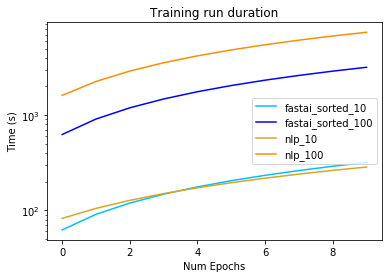

In [16]:
#hide
def get_timings(n_epochs, init, per_ep):
    #init=48
    #eps = n_epochs * 14.25
    eps = n_epochs * per_ep
    return init+eps

fastai_sorted_10 = [48, 14.25]
fastai_sorted_100 = [484, 142]
nlp_10 = [71, 11.27]
nlp_100 = [1290, 323]

timings_ls, timing_data = [], []
timings = [fastai_sorted_10,fastai_sorted_100, nlp_10, nlp_100]

n_eps = list(range(1,20,2))

for t in timings: timing_data.append([get_timings(n_epochs=n, init=t[0], per_ep=t[1]) for n in n_eps])

colors = ['deepskyblue','blue','goldenrod', 'darkorange']
labels = ['fastai_sorted_10','fastai_sorted_100','nlp_10','nlp_100']
for i,t in enumerate(timing_data):
    plt.plot(t, color=colors[i], label=labels[i])

plt.title('Training run duration')
plt.xlabel('Num Epochs')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.legend()
plt.show();

## Thanks for Reading 😃
As always, I would love to hear if you have any comments, thoughts or criticisms, you can find me on Twitter at [@mcgenergy](www.twitter.com/mcgenergy)

## [Appendix]

## Code:
For those curious, you can peek the code used in testing this below 👇

In [1]:
#hide_collapse
# Imports
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
# from fastai2.callback.all import *
# from fastai2.data.transforms import RandomSplitter
from fastai2.text.core import defaults

from nlp import load_dataset

import spacy,html
from spacy.symbols import ORTH

import timeit
import gc

### Fastai Testing
Init timing:

In [2]:
#hide_collapse
#%%timeit -n 1 -r 3

# Download data and save as csv
# senti_dataset = load_dataset('sentiment140', split='train[:100%]', download_mode='reuse_cache_if_exists')
# df = senti_dataset.data.to_pandas()
# df.to_csv('sentiment140.csv')

# Read data; the first 10% of the sentiment140 dataset, extraced from the `nlp` library and saved as a csv
#fn_10pct = 'sentiment140_10pct.csv'
fn = 'sentiment140.csv'
df = pd.read_csv(fn, index_col=None)

# SORT: Calculate text sample lengths
df['word_count'] = df['text'].str.split().map(len)

res=df['word_count'].values

# Create Dataloaders
dls = TextDataLoaders.from_csv(path='.', csv_fname=fn, valid_pct=0.2, bs=64, 
                               text_col='text', label_col='sentiment' , res=res)

1 epoch timing

In [6]:
#hide_collapse

del df, res
gc.collect()

# Do 1 pass of the training dataloader
s = """for b in dls.train: pass
    """

time = timeit.timeit(stmt=s, number=1, globals=globals()); time
time, time / len(dls.train)

(143.04122078799992, 0.007152061039399996)

### HuggingFace `nlp` Datasets Testing

Tokenizer, Numericalizer and Padding functions:

In [2]:
#hide_collapse
class SpacyTokenizerNLP():
    "Spacy tokenizer for `lang`"
    def __init__(self, lang='en', special_toks=None, buf_sz=5000):
        self.special_toks = ifnone(special_toks, defaults.text_spec_tok)
        nlp = spacy.blank(lang, disable=["parser", "tagger", "ner"])
        for w in self.special_toks: nlp.tokenizer.add_special_case(w, [{ORTH: w}])
        self.pipe,self.buf_sz = nlp.pipe,buf_sz
        
    def encodes(self, items):
        tmp = [list(doc) for doc in self.pipe(items, batch_size=self.buf_sz)]
        return {'tok_text_pre': [list(str(t) for t in l) for l in tmp]}

def make_vocab(count, min_freq=3, max_vocab=60000, special_toks=None):
    "Create a vocab of `max_vocab` size from `Counter` `count` with items present more than `min_freq`"
    vocab = [o for o,c in count.most_common(max_vocab) if c >= min_freq]
    special_toks = ifnone(special_toks, defaults.text_spec_tok)
    for o in reversed(special_toks): #Make sure all special tokens are in the vocab
        if o in vocab: vocab.remove(o)
        vocab.insert(0, o)
    vocab = vocab[:max_vocab]
    return vocab + [f'xxfake' for i in range(0, 8-len(vocab)%8)]

class NumericalizeNLP(Transform):
    "Reversible transform of tokenized texts to numericalized ids"
    def __init__(self, dsets=None, vocab=None, min_freq=3, max_vocab=60000, special_toks=None, pad_tok=None):
        store_attr(self, 'vocab,min_freq,max_vocab,special_toks,pad_tok')
        self.vocab, self.special_toks, self.min_freq, self.max_vocab = vocab, special_toks, min_freq, max_vocab
        self.o2i = None if vocab is None else defaultdict(int, {v:k for k,v in enumerate(vocab)})

        if self.vocab is None:
            count = Counter(p for o in dsets for p in o)
            self.vocab = make_vocab(count, min_freq=self.min_freq, max_vocab=self.max_vocab, special_toks=self.special_toks)
            self.o2i = defaultdict(int, {v:k for k,v in enumerate(self.vocab) if v != 'xxfake'})
    
    def encodes_nlp(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))
    def encodes_nlp(self, b): return {'toks' : [[self.o2i[o_] for o_ in oo] for oo in b['tok_text']]}
    
# Padding functions
def pad_seq(x, max_batch_len, pad_idx):    
    pad =  x.new_zeros(max_batch_len-x.size(0))+pad_idx
    return torch.cat([x, pad])
 
# Pad up to longest item in the batch and put batch on the GPU
def pad_batch(batch=None, pad_token_id=1):
    batch_inputs = list()
    max_size = max([len(item['toks']) for item in batch])
    for item in batch: batch_inputs += [pad_seq(item['toks'], max_size, pad_token_id)]
    return torch.stack(batch_inputs).cuda()

Data loading and processing functions:

In [9]:
#hide_collapse

# Download text, a clean version of the dataset is downloaded (not included in the timings), 'train[:10%]'
senti_dataset = load_dataset('sentiment140', split='train', download_mode='reuse_cache_if_exists')

spacy_tok = SpacyTokenizerNLP(lang='en', special_toks=defaults.text_spec_tok)

def preproc_and_tok(b): return spacy_tok.encodes(list(maps(*defaults.text_proc_rules, b['text'])))

def postproc(b): 
    return {'tok_text': [list(maps(*defaults.text_postproc_rules, _b)) for _b in b['tok_text_pre']]}

def get_tok_lengths(example_batch): return {'tok_lens': [len(e) for e in example_batch['toks']]}

def prepare_dataset(dataset):
    '''
        Takes a raw nlp dataset and returns a processed, tokenized, numericalised dataset
    '''
    # Apply processing rules and tokenize
    print('pre-proc and tokenize')
    dataset = dataset.map(preproc_and_tok, batched=True)

    # Apply post-processing rules 
    print('post=proc')
    dataset = dataset.map(postproc, batched=True)

    # Init Numericalizer and create vocab
    print('init numericalizer')
    numeric = NumericalizeNLP(dsets=dataset['tok_text_pre'], special_toks=defaults.text_spec_tok, pad_tok=1)

    # Numericalize
    print('numericalizing')
    dataset = dataset.map(numeric.encodes_nlp, batched=True)

    # Get sample lengths for sorting
    dataset=dataset.map(get_tok_lengths, batched=True)
    
    print('sorting')
    # Sort dataset from small to large
    dataset = dataset.sort('tok_lens')
    
    return dataset

Dataset sentiment140 downloaded and prepared to /home/morgan/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0. Subsequent calls will reuse this data.


Init Timing

In [10]:
#hide_collapse
#%%timeit -n 1 -r 1

# Do all of the text processing, tokenization and numericalization
senti_dataset_f = prepare_dataset(senti_dataset)

# Create train and test splits: `.train_test_split` is giving me an error, lets use `.select` instead
print('splitting')
train_split=int(len(senti_dataset_f)*0.8)
train_senti = senti_dataset_f.select(list(range(train_split)))
test_senti = senti_dataset_f.select(list(range(train_split, len(senti_dataset_f))))

# Format our dataset to outputs torch.Tensor to train a pytorch model
print('setting format')
columns = ['toks','sentiment']
train_senti.set_format(type='torch', columns=columns)
test_senti.set_format(type='torch', columns=columns)

# Instantiate out PyTorch Dataloaders 
print('init dataloaders')
train_dataloader = torch.utils.data.DataLoader(train_senti, batch_size=64, collate_fn=pad_batch)
test_dataloader = torch.utils.data.DataLoader(test_senti, batch_size=64, collate_fn=pad_batch)

  0%|          | 0/1600 [00:00<?, ?it/s]

pre-proc and tokenize


  0%|          | 1/1600 [00:00<02:57,  9.03it/s]

post=proc


100%|██████████| 1600/1600 [00:27<00:00, 58.42it/s]


init numericalizer
numericalizing


100%|██████████| 1600/1600 [00:34<00:00, 46.88it/s]


sorting


100%|██████████| 1600000/1600000 [06:56<00:00, 3842.47it/s]


splitting


100%|██████████| 320000/320000 [02:19<00:00, 2298.56it/s]

setting format
init dataloaders


Init timings:

- pre-proc and tokenize: 374
- post-proc : 26
- init numericalizer, numericalizing create vocab: 27
- get sample lengths: 28
- sorting: 416
- splitting: 416
- setting format: 1

Time `nlp` 1 epoch

In [11]:
#hide_collapse
#%%timeit

s = "for b in train_dataloader: pass"
time = timeit.timeit(stmt=s, number=1, globals=globals()); time
time, time / (len(train_senti)/64)

(323.86245587099984, 0.01619312279354999)